In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_squared_error, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, mean_squared_error, precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Прочтем содержимое файла train.csv в перемененную df.

Файл содержит информацию о клиентах банка, с некоторым набором признаков, описывающих клиента и целевым бинарным признаком - состояние дефолта (значение 0 или 1).

In [3]:
train = pd.read_csv('train.csv', sep=',') # основной датасет, используемый для построения признаков, нуждающийся в обработке
test = pd.read_csv('test.csv', sep=',') # тестовый датасет из 36 349 строк, в нем будем предсказывать целевую переменную
sample_submission = pd.read_csv('sample_submission.csv') # датасет из пробных предсказаний

In [4]:
#jОбъединение датасетов. Создадим у каждого датасета столбец sample, по которому потом сможем разделиться
train['sample'] = 1   # train
test['sample'] = 0    # test
test['default'] = -1 # это нужно предсказать пока просто заполним -1

df = pd.concat([train, test], ignore_index=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Какие признаки у нас есть.

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

В данных о клиентах присутствуют переменные разных типов.

Не все имеют числовую запись, а также есть пропущенные значения. 

Значит, нам необходима предварительная очистка данных

Перед этим мы посмотрим отчет ProfileReport чтобы узнать больше информации о каждом признаке в удобном и сжатом виде.

Запишем отчет в переменную, и выгрузим в файл

In [6]:
profile = pandas_profiling.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

С помощью ProfileReport мы увидели: 
1. Есть числовые, категориальные и бинарные признаки
2. Есть пропуски в признаке education (0.4% от общей выборки - можем удалить или заполнить значением 'None' - без образования)
3. Наблюдается высокая корреляция признаков home_address и work_address, а также sna и first_time (обратная корреляция) что выглядит логичным.
4. Выбросов не замечено

Запишем ProfileReport в файл html.

In [7]:
profile.to_file("pro_report_Potekhin.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df_agg = df.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(df.isnull().sum(), name='null'))\
    .append(pd.Series(df.dtypes, name='dtype'))\
    .transpose()

df_agg

<lambda> nunique  \
client_id         [25905, 63161, 25887, 16222, 101655, 41415, 28...  110148   
app_date          [01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...     120   
education                            [SCH, GRD, UGR, PGR, ACD, nan]       5   
sex                                                          [M, F]       2   
age                        [62, 59, 25, 53, 48, 27, 39, 50, 54, 29]      52   
car                                                          [Y, N]       2   
car_type                                                     [Y, N]       2   
decline_app_cnt                      [0, 2, 1, 3, 4, 6, 5, 7, 8, 9]      24   
good_work                                                    [0, 1]       2   
score_bki         [-2.00875292, -1.53227621, -1.40814226, -2.057...  102618   
bki_request_cnt                     [1, 3, 2, 0, 4, 7, 5, 8, 6, 13]      40   
region_rating                          [50, 80, 60, 40, 70, 20, 30]       7   
home_address                                              [1, 2, 3]       3   
work_address                                              [2, 3, 1]       3   
income            [18000, 19000, 30000, 10000, 15000, 28000, 450...    1207   
sna                                                    [4, 1, 2, 3]       4   
first_time                                             [1, 4, 3, 2]       4   
foreign_passport                                             [N, Y]       2   
default                                                  [0, 1, -1]       3   
sample                                                       [1, 0]       2   

                 null    dtype  
client_id           0    int64  
app_date            0   object  
education         478   object  
sex                 0   object  
age                 0    int64  
car                 0   object  
car_type            0   object  
decline_app_cnt     0    int64  
good_work           0    int64  
score_bki           0  float64  
bki_request_cnt     0    int64  
region_rating       0    int64  
home_address        0    int64  
work_address        0    int64  
income              0    int64  
sna                 0    int64  
first_time          0    int64  
foreign_passport    0   object  
default             0    int64  
sample              0    int64

In [9]:
# Предобработка. Здесь опишем некоторые функции 
df['education'].fillna('no_edu', inplace = True)

# Функция для построения Боксплотов
def get_boxplot(column):
    plt.figure(figsize = (18, 9))
    sns.boxplot( y = df[column], x = df['default'])
    plt.title('Boxplot for ' + column)
    plt.show()

# Функция для построения распределений
def get_hist(column):
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.histplot(df[column][df[column] > 0].dropna(), kde = False)#, rug = False)
    plt.title('Hist for ' + column)
    plt.show()

# Поиск выбросов с помощью межквартильного расстояния
def fun_IQR(df,loc):
    perc25 = df[loc].quantile(0.25)
    perc75 = df[loc].quantile(0.75)
    IQR = perc75 - perc25

    return print('25-й перцентиль: {},'.format(perc25),'\n75-й перцентиль: {},'.format(perc75),
                 "\n\nIQR: {}, ".format(IQR),"\nГраницы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, 
                                                                                      l=perc75 + 1.5*IQR))
# Создает dummy_переменные для категориальных признаков
def get_ohe_featuries(data_frame, column):
    ohe = OneHotEncoder()
    new_ohe_features = ohe.fit_transform(data_frame[column].values.reshape(-1,1)).toarray()
    tmp = pd.DataFrame(new_ohe_features, columns = [column + ' = ' + str(i) for i in list(data_frame[column].unique())])
    return tmp
    #data = pd.concat([data,tmp], axis = 1)

# Создает числовые признаки из категориальных и каких-либо связанных с ними
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))
        
# Функция для выдачи метрик
#def print_logisitc_metrics(y_true, y_pred):
#    acc = accuracy_score(y_true, y_pred)
#    f1 = f1_score(y_true, y_pred)
#    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')
    
def print_logisitc_metrics(y_true, y_pred):
    print('accuracy_score:',round(accuracy_score(y_true, y_pred),3))
    print('precision_score:',round(precision_score(y_true, y_pred),3))
    print('recall_score:',round(recall_score(y_true, y_pred),3))
    print('f1_score:',round(f1_score(y_true, y_pred),3))
    print('MSE: {}'.format(np.round(mean_squared_error(y_true, y_pred), 3)))


#df_num = df.select_dtypes(include=[np.number])
#num_cols = df_num.columns.values[1:-1] 

#df_non_num = df.select_dtypes(exclude=[np.number])
#non_num_cols = df_non_num.columns.values

# Определимся с типами признаков
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

Посмотрим на распределение числовых данных:

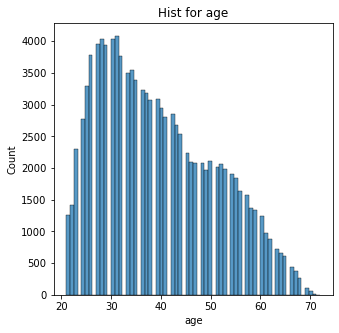

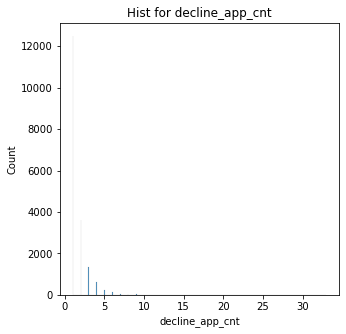

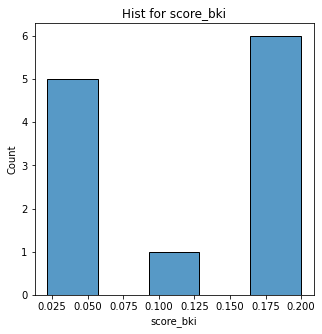

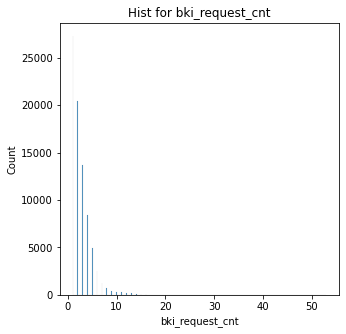

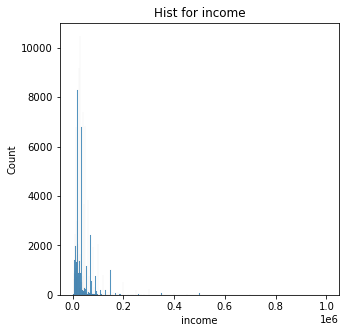

In [10]:
for col in num_cols:
    get_hist(col)

После построения гистограмм стало очевидно, что распределения некоторых числовых переменных имеют тяжёлый правый хвост.

Построим графики распределения логарифмированных переменных.

In [11]:
df_log = df.copy()
for col in num_cols:
    df_log[col] = df_log[col].apply(lambda x: np.log(x+1))

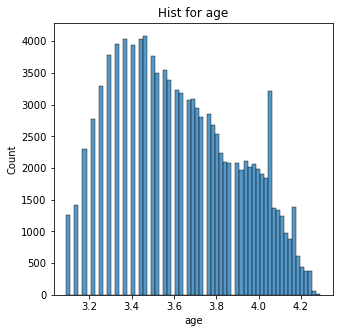

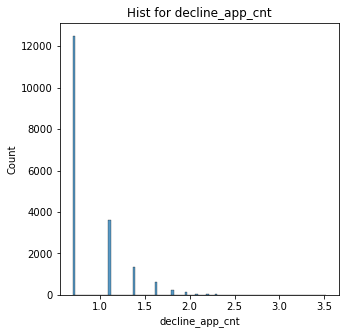

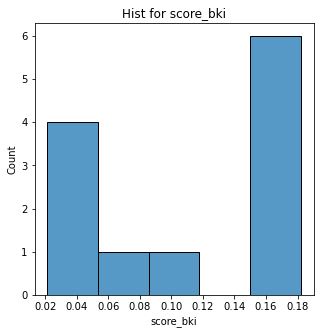

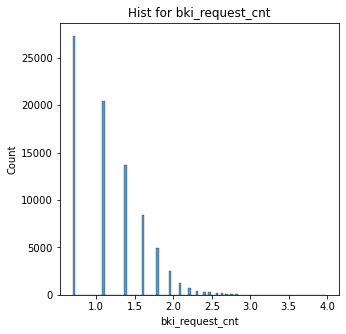

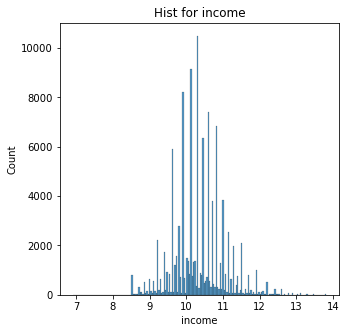

In [12]:
for col in num_cols:
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.histplot(df_log[col][df_log[col] > 0].dropna(), kde = False)#, rug = False)
    plt.title('Hist for ' + col)
    plt.show()

Признаки income и score_bki стали менее смещёнными.

Построим графики boxplot для численных переменных в разрезе целевой переменной.

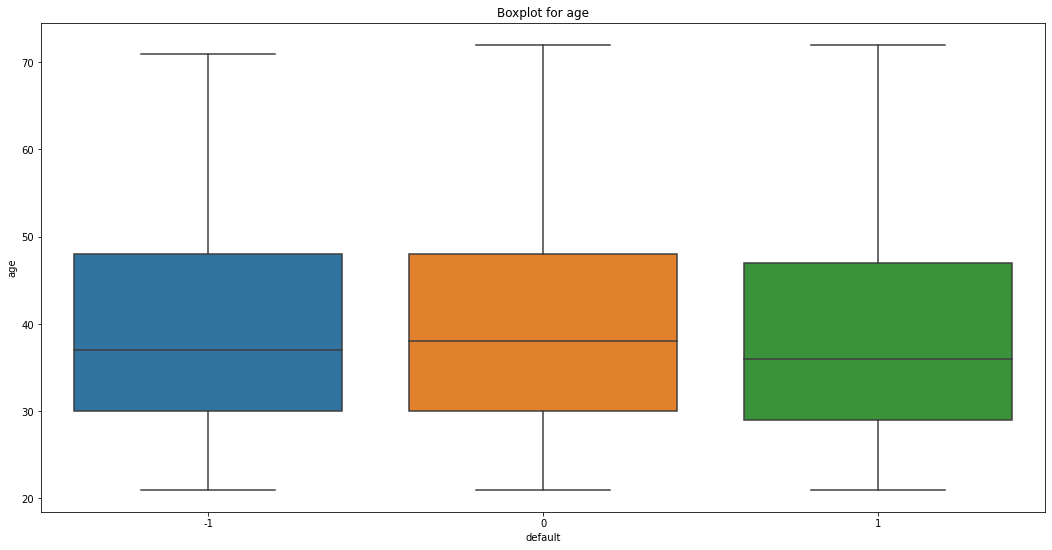

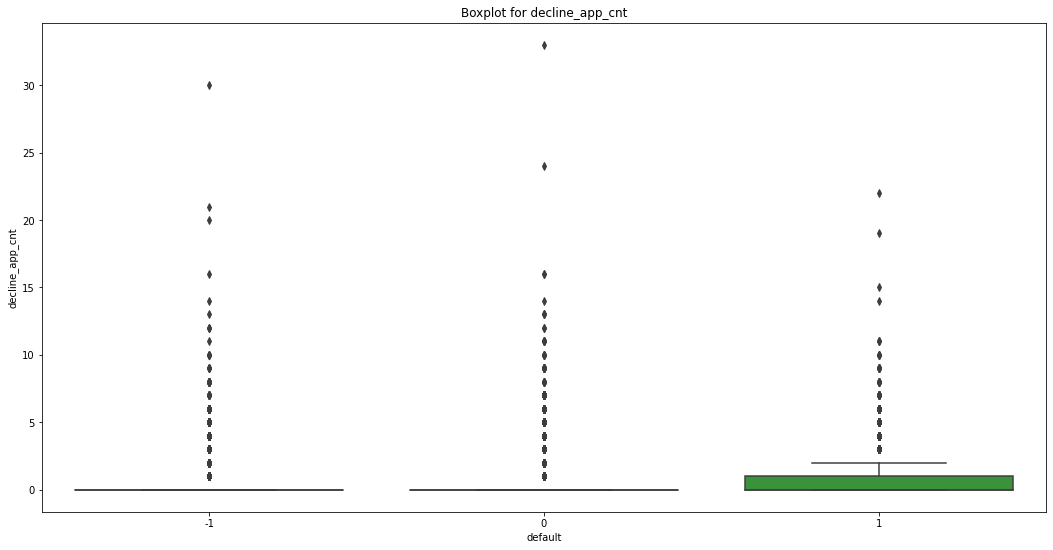

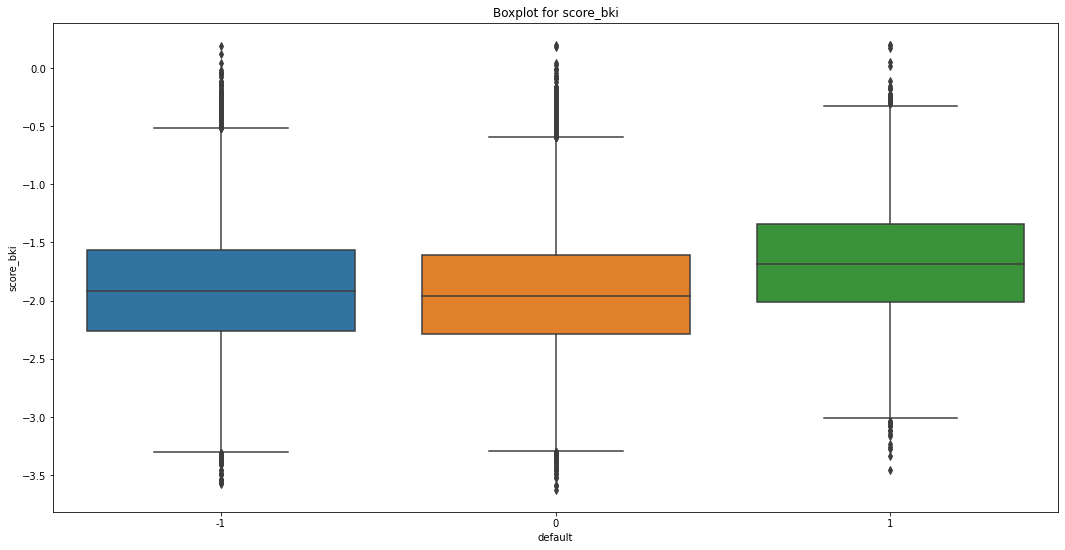

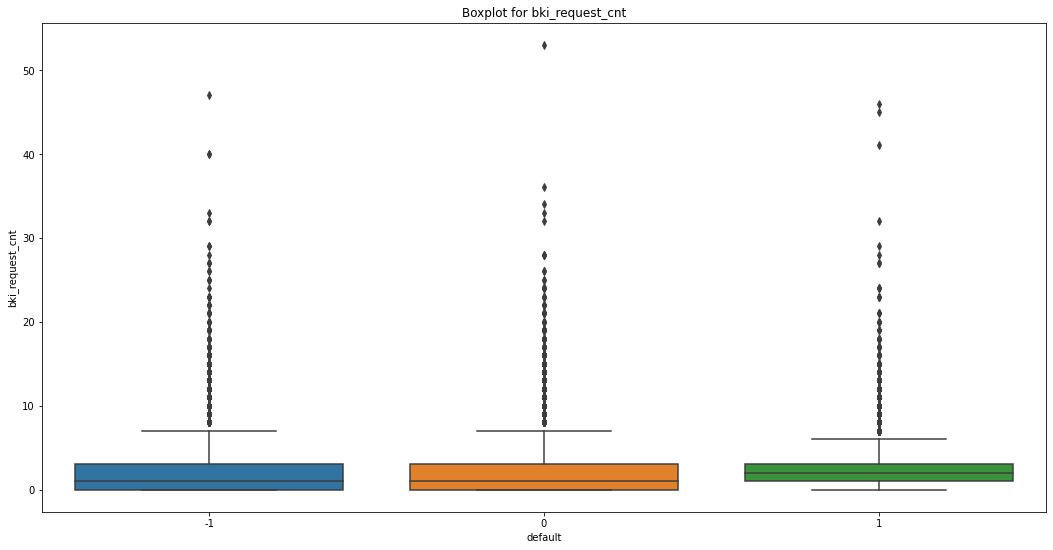

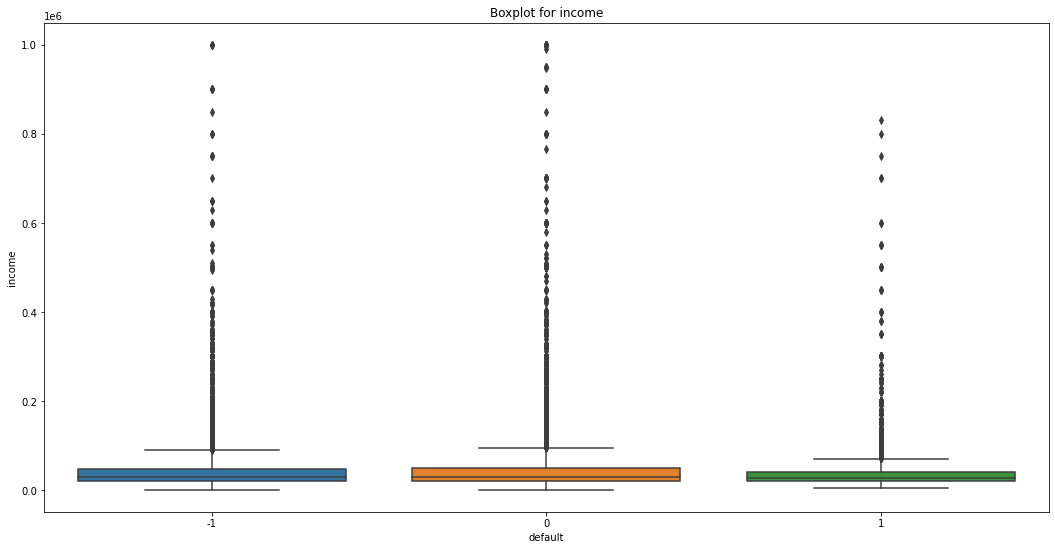

In [13]:
for col in num_cols:
    get_boxplot(col)

Выводы:
1. Дефолтные клиенты младше
2. Дефолтные клиенты в среднем имеют большое количество отмененных заявок
3. Дефолтные клиенты в среднем имеют больше запросов в БКИ
4. Дефолтные клиенты в среднем имеют более низкий доход
5. Дефолтные клиенты в среднем имеют более высокий скоринговый балл

Преобразуем значения бинарных признаков в числа 0 или 1. 

In [14]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

client_id   app_date education  sex  age  car  car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH    1   62    1         1                0   
1      63161  12MAR2014       SCH    0   59    0         0                0   
2      25887  01FEB2014       SCH    1   25    1         0                2   
3      16222  23JAN2014       SCH    0   53    0         0                0   
4     101655  18APR2014       GRD    1   48    0         0                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time  foreign_passport  default  sample  
0             2   18000    4           1                 0        0       1  
1             3   19000    4           1                 0        0       1  
2             2   30000    1           4                 1        0       1  
3             3   10000    1           3                 0        0       1  
4             3   30000    1           4                 1        0       1

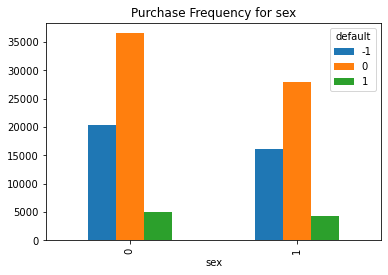

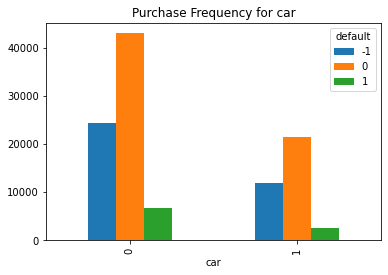

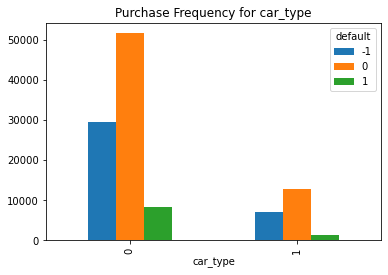

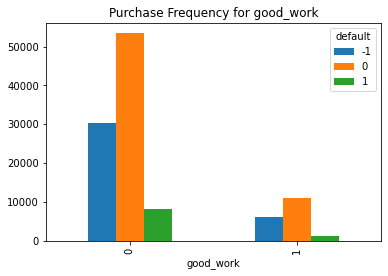

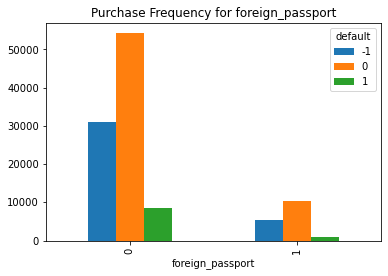

In [15]:
for col in bin_cols:
    pd.crosstab(df[col],df.default).plot(kind='bar')
    plt.title('Purchase Frequency for ' + col)
    plt.xlabel(col)

Из бинарных признаков - sex является наименее существенным прогнозирующим фактором

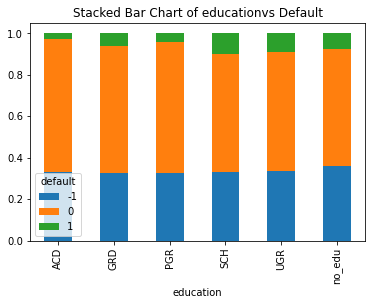

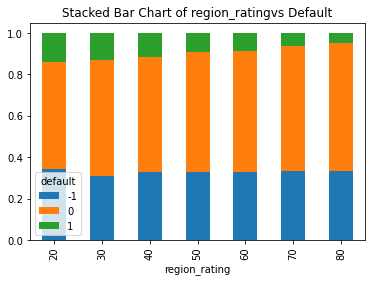

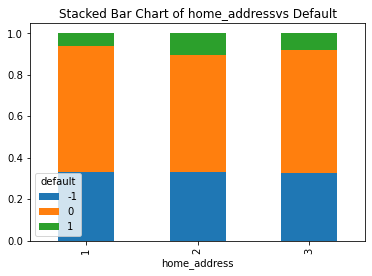

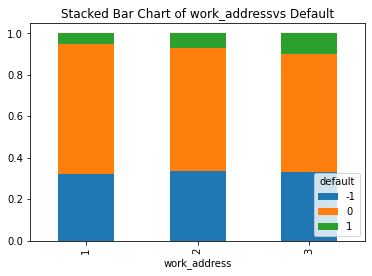

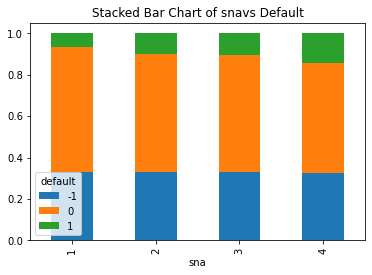

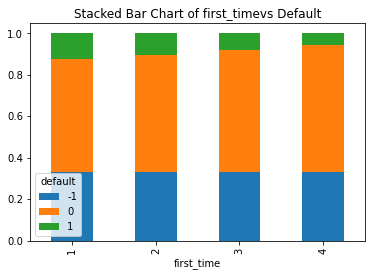

In [16]:
for col in cat_cols:    
    table=pd.crosstab(df[col],df.default)
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title('Stacked Bar Chart of '+col+'vs Default')
    plt.xlabel(col)
    plt.savefig(col+'_vs_default_stack')

Посмотрим на корреляцию переменных.

client_id       sex       age       car  car_type  \
client_id          1.000000 -0.033333  0.015535 -0.022271 -0.024695   
sex               -0.033333  1.000000 -0.134411  0.277470  0.224822   
age                0.015535 -0.134411  1.000000 -0.048263 -0.044402   
car               -0.022271  0.277470 -0.048263  1.000000  0.698760   
car_type          -0.024695  0.224822 -0.044402  0.698760  1.000000   
decline_app_cnt   -0.021508  0.019436 -0.111454 -0.033183 -0.043189   
good_work          0.003447 -0.044026 -0.072233  0.001565  0.016160   
score_bki         -0.061653 -0.046214 -0.104682 -0.043080 -0.042107   
bki_request_cnt   -0.027428 -0.048826  0.046975 -0.027088  0.003771   
region_rating      0.005720  0.108951 -0.089147  0.062586  0.103873   
home_address       0.163686  0.036701  0.012135 -0.024142 -0.011276   
work_address       0.163422  0.071493 -0.004509 -0.008410  0.001170   
income            -0.002069  0.192553 -0.018664  0.249159  0.304385   
sna               -0.001624 -0.004148 -0.058364 -0.074095 -0.087095   
first_time         0.016865  0.014069  0.078644  0.090976  0.102278   
foreign_passport  -0.013739  0.085924 -0.040238  0.106893  0.145373   
default           -0.012182  0.002775 -0.005927 -0.018266 -0.024423   
sample             0.002844 -0.005135  0.003864 -0.002382 -0.003309   

                  decline_app_cnt  good_work  score_bki  bki_request_cnt  \
client_id               -0.021508   0.003447  -0.061653        -0.027428   
sex                      0.019436  -0.044026  -0.046214        -0.048826   
age                     -0.111454  -0.072233  -0.104682         0.046975   
car                     -0.033183   0.001565  -0.043080        -0.027088   
car_type                -0.043189   0.016160  -0.042107         0.003771   
decline_app_cnt          1.000000  -0.029525   0.187869         0.159927   
good_work               -0.029525   1.000000   0.005063         0.007789   
score_bki                0.187869   0.005063   1.000000         0.157451   
bki_request_cnt          0.159927   0.007789   0.157451         1.000000   
region_rating           -0.038254   0.070839   0.007132         0.006780   
home_address             0.011095  -0.008650   0.016056         0.005331   
work_address             0.015410  -0.011993   0.016683         0.001763   
income                  -0.022241   0.026447  -0.011721         0.080475   
sna                      0.062434  -0.052889   0.067646         0.004577   
first_time              -0.070939   0.058787  -0.069805         0.012247   
foreign_passport        -0.024492   0.048491  -0.020069         0.006069   
default                  0.046868  -0.018322   0.065020         0.026492   
sample                   0.004536  -0.002376  -0.000538        -0.002931   

                  region_rating  home_address  work_address    income  \
client_id              0.005720      0.163686      0.163422 -0.002069   
sex                    0.108951      0.036701      0.071493  0.192553   
age                   -0.089147      0.012135     -0.004509 -0.018664   
car                    0.062586     -0.024142     -0.008410  0.249159   
car_type               0.103873     -0.011276      0.001170  0.304385   
decline_app_cnt       -0.038254      0.011095      0.015410 -0.022241   
good_work              0.070839     -0.008650     -0.011993  0.026447   
score_bki              0.007132      0.016056      0.016683 -0.011721   
bki_request_cnt        0.006780      0.005331      0.001763  0.080475   
region_rating          1.000000      0.232971      0.254062  0.207494   
home_address           0.232971      1.000000      0.726535  0.037882   
work_address           0.254062      0.726535      1.000000  0.052153   
income                 0.207494      0.037882      0.052153  1.000000   
sna                   -0.080876      0.114541      0.111162 -0.090882   
first_time             0.090701     -0.058430     -0.062266  0.109453   
foreign_passport       0.257844      0.039632      0.04

<AxesSubplot:>

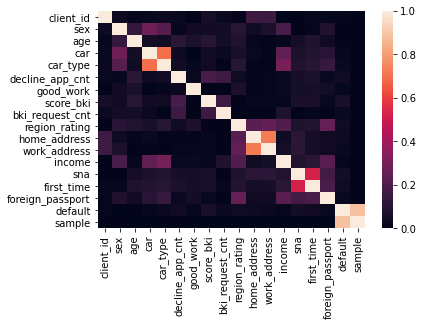

In [17]:
display(df.corr())
sns.heatmap(df.corr().abs(), vmin=0, vmax=1)

Как ранее предполагалось - наблюдается высокая корреляция между признаками home_address и work_address - можем удалить из них один, далее узнаем, какой из них более значим

Также высокая обратная корреляция между sna и first_time - чем дольше клиент в банке, тем больше о нем информации и связей с другими участниками.

Построим корреляцию Пирсона и посмотрим какой признак самый значимый из числовых?

In [18]:
#Корреляция Пирсона
for col in num_cols:
    print('Значение корреляции Пирсона c целевой переменной для столбца ' + col)
    print(np.corrcoef(df.default, df[col])[0, 1])   

Значение корреляции Пирсона c целевой переменной для столбца age
-0.005926681179673856
Значение корреляции Пирсона c целевой переменной для столбца decline_app_cnt
0.04686776877031134
Значение корреляции Пирсона c целевой переменной для столбца score_bki
0.06502034753002335
Значение корреляции Пирсона c целевой переменной для столбца bki_request_cnt
0.026492426268648554
Значение корреляции Пирсона c целевой переменной для столбца income
-0.012701150641054657


<AxesSubplot:>

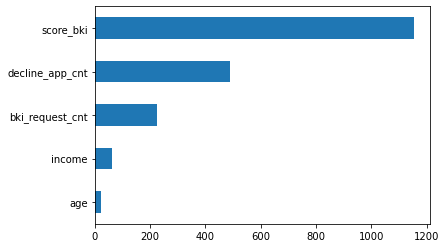

In [19]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

score_bki значимый признак для будущей модели

age - наименее значимый

Для оценки значимости категориальных и бинарных признаков 
будем использовать функцию mutual_info_classif из библиотеки sklearn.

<AxesSubplot:>

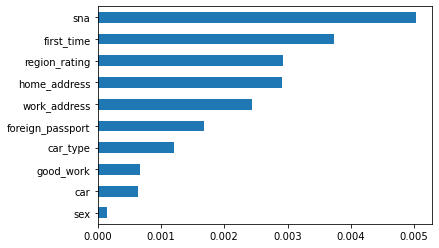

In [20]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols[1:]], df['default'],
                                     discrete_features = True), index = bin_cols + cat_cols[1:])
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Признаки sna, first_time, region_rating, home_address - более значимы для будущей модели.

sex, car, good_work, car_type, foreign_passport - менее значимы.

Создадим отедльную матрицу dummy_переменных из всех категориальных признаков с помощью метода OneHotEncoder.

Здесь для каждого кодируемого категориального признака создаются N новых признаков, где N — число категорий. 
Каждый i-й новый признак — бинарный характеристический признак i-й категории

Разобъем датасет обратно на тестовый и тренировочный

In [21]:
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(['sample'], axis=1)

In [22]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train_df[cat_cols].values)
display(X_cat.shape)

(73799, 27)

In [23]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train_df[num_cols].values)

Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, 

разделив при этом признаки и целевую переменную.

In [24]:
X = np.hstack([X_num, train_df[bin_cols].values, X_cat])
Y = train_df['default'].values

In [25]:
#Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Обучим наивную модель на стандартных настройках логистической регрессии

И построим матрицу ошибок для нашей модели

[True Negative  False Positive]

[False Negative True Positive]

In [26]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print_logisitc_metrics(y_test, y_pred)
display(confusion_matrix(y_test, y_pred))

accuracy_score: 0.875
precision_score: 0.396
recall_score: 0.021
f1_score: 0.04
MSE: 0.125


array([[12875,    58],
       [ 1789,    38]], dtype=int64)

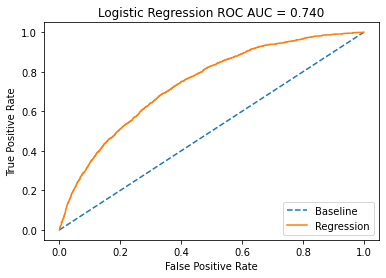

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Матрица ошибок говорит о том, что 1789 ложно-положительных событий, т.е. такому большому числу человек было отказано ошибочно.

Получили очень низкий показатель F1-score

На данный момент качество модели среднее, т.к. показаетль AUC дает нам не просто прямую, уже появилась прогнозтическая сила. Попробуем увеличить наши метрики за счет гиперпараметров

Узнаем какие значения гиперпараметров оптимальны

In [28]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [29]:
logreg = LogisticRegression(C = 1.0, penalty = 'l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print_logisitc_metrics(y_test, y_pred)
display(confusion_matrix(y_test, y_pred))

accuracy_score: 0.875
precision_score: 0.396
recall_score: 0.021
f1_score: 0.04
MSE: 0.125


array([[12875,    58],
       [ 1789,    38]], dtype=int64)

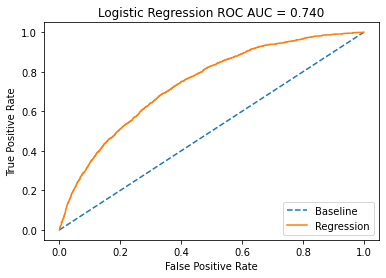

In [30]:
model = LogisticRegression(C = 1.0, penalty = 'l2')
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

После поиска и применения значений гиперпараметров результат не изменился.

Воспользуемся параметром class_weight='balanced'

In [31]:
logreg = LogisticRegression(class_weight='balanced')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print_logisitc_metrics(y_test, y_pred)
display(confusion_matrix(y_test, y_pred))

accuracy_score: 0.664
precision_score: 0.222
recall_score: 0.683
f1_score: 0.335
MSE: 0.336


array([[8553, 4380],
       [ 579, 1248]], dtype=int64)

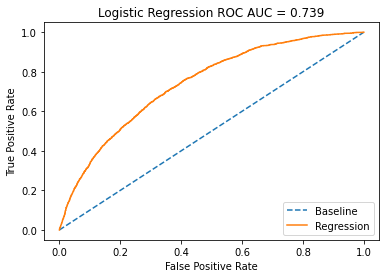

In [32]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

После применения class_weight='balanced' значительно улучшился показатель f1_score, но accuracy_score снизился. Также совем немного упал ROC AUC

Попробуем другие модели обучения

In [33]:
#Список моделей обучения

lr = LogisticRegression()

tree = DecisionTreeClassifier()

extra_tree = ExtraTreeClassifier() 

ada = AdaBoostClassifier()

bagg = BaggingClassifier() 

gboost = GradientBoostingClassifier()

rforest = RandomForestClassifier()

model_list = [lr, tree, extra_tree, ada, bagg, gboost, rforest]

In [34]:
for models in model_list:
    model = models

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Информация по модели: ' + str(models))
    print_logisitc_metrics(y_test, y_pred)
    display(confusion_matrix(y_test, y_pred))

Информация по модели: LogisticRegression()
accuracy_score: 0.875
precision_score: 0.396
recall_score: 0.021
f1_score: 0.04
MSE: 0.125


array([[12875,    58],
       [ 1789,    38]], dtype=int64)

Информация по модели: DecisionTreeClassifier()
accuracy_score: 0.785
precision_score: 0.195
recall_score: 0.236
f1_score: 0.213
MSE: 0.215


array([[11153,  1780],
       [ 1396,   431]], dtype=int64)

Информация по модели: ExtraTreeClassifier()
accuracy_score: 0.796
precision_score: 0.191
recall_score: 0.201
f1_score: 0.196
MSE: 0.204


array([[11378,  1555],
       [ 1459,   368]], dtype=int64)

Информация по модели: AdaBoostClassifier()
accuracy_score: 0.875
precision_score: 0.4
recall_score: 0.024
f1_score: 0.045
MSE: 0.125


array([[12867,    66],
       [ 1783,    44]], dtype=int64)

Информация по модели: BaggingClassifier()
accuracy_score: 0.864
precision_score: 0.276
recall_score: 0.059
f1_score: 0.097
MSE: 0.136


array([[12653,   280],
       [ 1720,   107]], dtype=int64)

Информация по модели: GradientBoostingClassifier()
accuracy_score: 0.876
precision_score: 0.451
recall_score: 0.018
f1_score: 0.034
MSE: 0.124


array([[12894,    39],
       [ 1795,    32]], dtype=int64)

Информация по модели: RandomForestClassifier()
accuracy_score: 0.874
precision_score: 0.37
recall_score: 0.028
f1_score: 0.052
MSE: 0.126


array([[12846,    87],
       [ 1776,    51]], dtype=int64)

ROC AUC для модели: LogisticRegression()


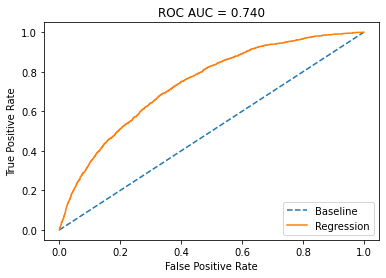

ROC AUC для модели: DecisionTreeClassifier()


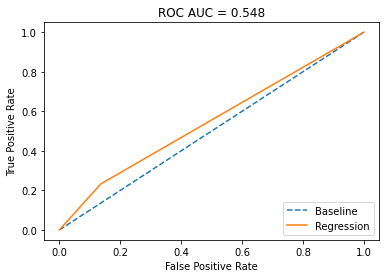

ROC AUC для модели: ExtraTreeClassifier()


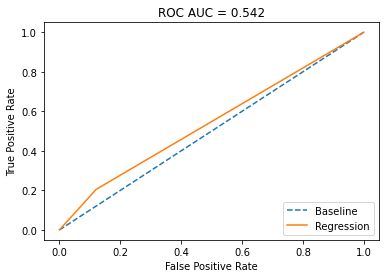

ROC AUC для модели: AdaBoostClassifier()


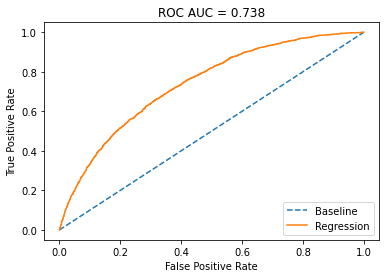

ROC AUC для модели: BaggingClassifier()


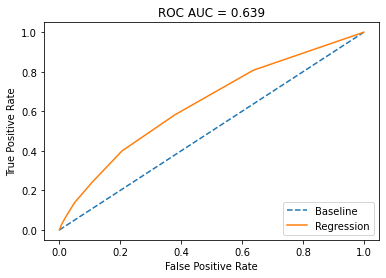

ROC AUC для модели: GradientBoostingClassifier()


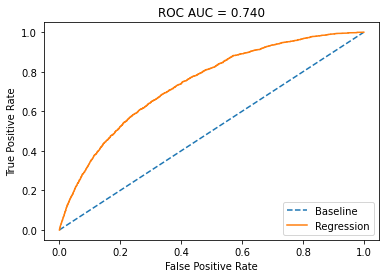

ROC AUC для модели: RandomForestClassifier()


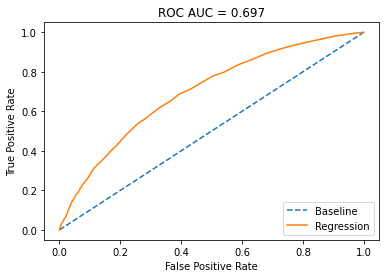

In [35]:
for models in model_list:
    model = models
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:,1]


    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    print('ROC AUC для модели: ' + str(models))
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

У всех испытанных моделей достаточно неплохие показатели accuracy_score и mse, но стабильно низкий f1-score

Самые высокие показатели ROC AUC у моделей:
1. GradientBoostingClassifier()
2. LogisticRegression()
3. AdaBoostClassifier()

Попробуем поработать над преобразованием переменных

При этом сделаем  бэкап данных.

In [36]:
data = df.copy()

In [37]:
data = df.copy()
# Заполним пропуски в education
data.education.fillna('No_data',inplace = True)

# Добавим признаки по дням недели и месяцам
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_day'] = data.app_date.dt.day
data['app_month'] = data.app_date.dt.month
data.drop(['app_date'],  axis = 1, inplace = True)

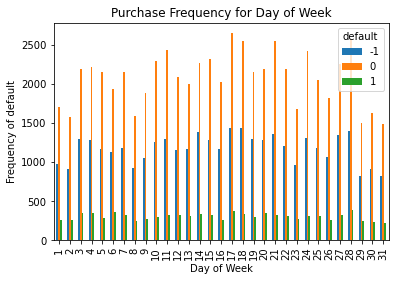

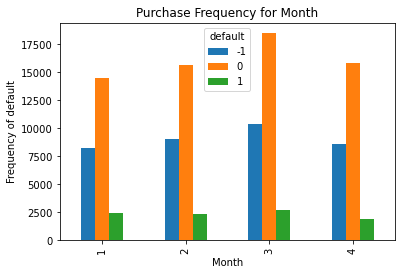

In [38]:
pd.crosstab(data.app_day,data.default).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of default')
plt.savefig('default_dayofweek_bar')

pd.crosstab(data.app_month,data.default).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of default')
plt.savefig('default_month_bar')

День, месяц, год не имеют значения для нашей задачи.

In [39]:
data.drop(['app_day','app_month'],  axis = 1, inplace = True)

In [40]:
df.education.value_counts()

SCH       57998
GRD       34768
UGR       14748
PGR        1865
no_edu      478
ACD         291
Name: education, dtype: int64

Есть 3 теории как поступить с education

1. Можем предположить, что значения признака education - это разные уровни образования. И тогда необходимо заменить значения этого признака на цифры от 1 до 6. Но мы точно не знаем, какое значение выше или ниже по рангу (ниже только предположение). Можно оттолкнуться от количества того или иного значения.

Старшая средняя школа: SCH - High School

Высшее образование делится на 3 этапа:

UGR - Undergraduate или колледж

GRD - Graduate или бакалавр

PGR - Postgraduate соответственно магистр

Научная стпень:

ACD - от кандидата наук до академика

2. Делать dummy_переменные из этого признака с помощью OneHotEncoder

3. Заменить этот признак по такому принципу: пусть вместо строкового значения, будет средний доход для данного значения. Предположим, что зарплата зависит от уровня образования.

Для проверки гипотезы - скопирую датасет и сделаю некоторые тесты.

In [41]:
df_ed = df.copy()
ed_dict = {'no_edu': 0, 'SCH' : 1, 'UGR' : 2, 'GRD' : 3, 'PGR' : 4, 'ACD' : 5}
df_ed['education'] = df_ed['education'].map(ed_dict)

<AxesSubplot:>

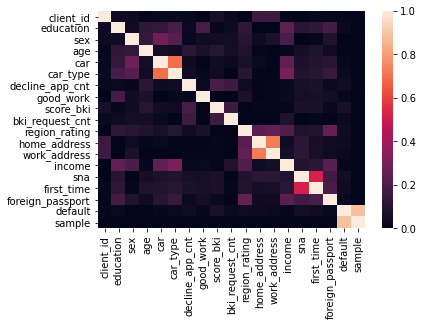

In [42]:
df_ed.corr()
sns.heatmap(df_ed.corr().abs(), vmin=0, vmax=1)

Реализуя предположение об уровнях образования, была обнаружена взаимосвязь, хоть и небольшая, но сразу с несколькими другими признаками:
1. Наличие авто
2. Тип авто
3. Хорошая работа
4. Доход
5. Наличие заграничного паспорта

Похоже на некие атрибуты "хорошей жизни". 
Возможно предположение было верно.

Возможно стоит пока остановится на этом.

In [43]:
data['education'] = data['education'].map(ed_dict)
data.head()

client_id  education  sex  age  car  car_type  decline_app_cnt  good_work  \
0      25905          1    1   62    1         1                0          0   
1      63161          1    0   59    0         0                0          0   
2      25887          1    1   25    1         0                2          0   
3      16222          1    0   53    0         0                0          0   
4     101655          3    1   48    0         0                0          1   

   score_bki  bki_request_cnt  region_rating  home_address  work_address  \
0  -2.008753                1             50             1             2   
1  -1.532276                3             50             2             3   
2  -1.408142                1             80             1             2   
3  -2.057471                2             50             2             3   
4  -1.244723                1             60             2             3   

   income  sna  first_time  foreign_passport  default  sample  
0   18000    4           1                 0        0       1  
1   19000    4           1                 0        0       1  
2   30000    1           4                 1        0       1  
3   10000    1           3                 0        0       1  
4   30000    1           4                 1        0       1

In [44]:
# Удалим признак адреса работы как скоррелированный с адресом жилья
data.drop(['work_address'],  axis = 1, inplace = True)

Заменим 2 признака о машинах на 1. Значения будут такими:

0 - если машины нет вообще

1 - если есть и тип авто 0

2 - если есть и тип авто 1

In [45]:
car_type_double = []
for i in range(len(data)):
    if (data.car[i] + data.car_type[i]) == 0:
        car_type_double.append(0)
    elif (data.car[i] + data.car_type[i]) == 1:
        car_type_double.append(1)
    elif (data.car[i] + data.car_type[i]) == 2:
        car_type_double.append(2)
data['car_type_double'] = car_type_double

In [46]:
data.drop(['car','car_type'],  axis = 1, inplace = True)

In [47]:
a = train_df[(train_df.age >= 20) & (train_df.age < 30)].client_id.nunique()
b = train_df[(train_df.age >= 30) & (train_df.age < 35)].client_id.nunique()
c = train_df[(train_df.age >= 35) & (train_df.age < 40)].client_id.nunique()
d = train_df[(train_df.age >= 40) & (train_df.age < 45)].client_id.nunique()
e = train_df[(train_df.age >= 45) & (train_df.age < 50)].client_id.nunique()
f = train_df[(train_df.age >= 50) & (train_df.age < 55)].client_id.nunique()
g = train_df[(train_df.age >= 55) & (train_df.age < 60)].client_id.nunique()
h = train_df[(train_df.age >= 60)].client_id.nunique()

a1 = train_df[(train_df.age >= 20) & (train_df.age < 30)].default.sum()
b1 = train_df[(train_df.age >= 30) & (train_df.age < 35)].default.sum()
c1 = train_df[(train_df.age >= 35) & (train_df.age < 40)].default.sum()
d1 = train_df[(train_df.age >= 40) & (train_df.age < 45)].default.sum()
e1 = train_df[(train_df.age >= 45) & (train_df.age < 50)].default.sum()
f1 = train_df[(train_df.age >= 50) & (train_df.age < 55)].default.sum()
g1 = train_df[(train_df.age >= 55) & (train_df.age < 60)].default.sum()
h1 = train_df[(train_df.age >= 60)].default.sum()

display(a1/a)
display(b1/b)
display(c1/c)
display(d1/d)
display(e1/e)
display(f1/f)
display(g1/g)
display(h1/h)

0.13944267604847266

0.13103721298495646

0.1312348215953671

0.11993060073736717

0.11837606837606837

0.11141939252336448

0.11078998073217726

0.12628624883068287

Есть смысл сделать 2 категории возраста:

1. До 40 и От 60 и выше

2. От 40 до 60

In [48]:
age_cat = []
for i in range(len(data)):
    if (data.age[i] < 40) or (data.age[i] >= 60):
        age_cat.append(1)
    else:
        age_cat.append(0)

In [49]:
data['age_cat'] = age_cat
data['age_cat'].value_counts()

1    68026
0    42122
Name: age_cat, dtype: int64

In [50]:
data.drop(['age'],  axis = 1, inplace = True)

In [51]:
data.head()

client_id  education  sex  decline_app_cnt  good_work  score_bki  \
0      25905          1    1                0          0  -2.008753   
1      63161          1    0                0          0  -1.532276   
2      25887          1    1                2          0  -1.408142   
3      16222          1    0                0          0  -2.057471   
4     101655          3    1                0          1  -1.244723   

   bki_request_cnt  region_rating  home_address  income  sna  first_time  \
0                1             50             1   18000    4           1   
1                3             50             2   19000    4           1   
2                1             80             1   30000    1           4   
3                2             50             2   10000    1           3   
4                1             60             2   30000    1           4   

   foreign_passport  default  sample  car_type_double  age_cat  
0                 0        0       1                2        1  
1                 0        0       1                0        0  
2                 1        0       1                1        1  
3                 0        0       1                0        0  
4                 1        0       1                0        0

client_id  education       sex  decline_app_cnt  good_work  \
client_id          1.000000   0.041653 -0.033333        -0.021508   0.003447   
education          0.041653   1.000000  0.039922        -0.030046   0.181600   
sex               -0.033333   0.039922  1.000000         0.019436  -0.044026   
decline_app_cnt   -0.021508  -0.030046  0.019436         1.000000  -0.029525   
good_work          0.003447   0.181600 -0.044026        -0.029525   1.000000   
score_bki         -0.061653  -0.018110 -0.046214         0.187869   0.005063   
bki_request_cnt   -0.027428   0.033033 -0.048826         0.159927   0.007789   
region_rating      0.005720   0.124412  0.108951        -0.038254   0.070839   
home_address       0.163686   0.001564  0.036701         0.011095  -0.008650   
income            -0.002069   0.242338  0.192553        -0.022241   0.026447   
sna               -0.001624  -0.106385 -0.004148         0.062434  -0.052889   
first_time         0.016865   0.124586  0.014069        -0.070939   0.058787   
foreign_passport  -0.013739   0.178625  0.085924        -0.024492   0.048491   
default           -0.012182  -0.029508  0.002775         0.046868  -0.018322   
sample             0.002844   0.002166 -0.005135         0.004536  -0.002376   
car_type_double   -0.025347   0.171862  0.274827        -0.040929   0.008914   
age_cat           -0.015324   0.104177  0.075149         0.070624   0.038241   

                  score_bki  bki_request_cnt  region_rating  home_address  \
client_id         -0.061653        -0.027428       0.005720      0.163686   
education         -0.018110         0.033033       0.124412      0.001564   
sex               -0.046214        -0.048826       0.108951      0.036701   
decline_app_cnt    0.187869         0.159927      -0.038254      0.011095   
good_work          0.005063         0.007789       0.070839     -0.008650   
score_bki          1.000000         0.157451       0.007132      0.016056   
bki_request_cnt    0.157451         1.000000       0.006780      0.005331   
region_rating      0.007132         0.006780       1.000000      0.232971   
home_address       0.016056         0.005331       0.232971      1.000000   
income            -0.011721         0.080475       0.207494      0.037882   
sna                0.067646         0.004577      -0.080876      0.114541   
first_time        -0.069805         0.012247       0.090701     -0.058430   
foreign_passport  -0.020069         0.006069       0.257844      0.039632   
default            0.065020         0.026492      -0.035777      0.033045   
sample            -0.000538        -0.002931      -0.002780      0.001525   
car_type_double   -0.046230        -0.014112       0.088279     -0.019815   
age_cat            0.070585        -0.033683       0.052450      0.023294   

                    income       sna  first_time  foreign_passport   default  \
client_id        -0.002069 -0.001624    0.016865         -0.013739 -0.012182   
education         0.242338 -0.106385    0.124586          0.178625 -0.029508   
sex               0.192553 -0.004148    0.014069          0.085924  0.002775   
decline_app_cnt  -0.022241  0.062434   -0.070939         -0.024492  0.046868   
good_work         0.026447 -0.052889    0.058787          0.048491 -0.018322   
score_bki        -0.011721  0.067646   -0.069805         -0.020069  0.065020   
bki_request_cnt   0.080475  0.004577    0.012247          0.006069  0.026492   
region_rating     0.207494 -0.080876    0.090701          0.257844 -0.035777   
home_address      0.037882  0.114541   -0.058430          0.039632  0.033045   
income            1.000000 -0.090882    0.109453          0.227443 -0.012701   
sna              -0.090882  1.000000   -0.526594         -0.172393  0.049113   
first_time        0.109453 -0.526594    1.000000          0.193817 -0.039639   
foreign_passport  0.227443 -0.172393    0.193817          1.000000 -0.022144   
default          -0.012701  0.049113   -0.039639         -0.022144  1.

<AxesSubplot:>

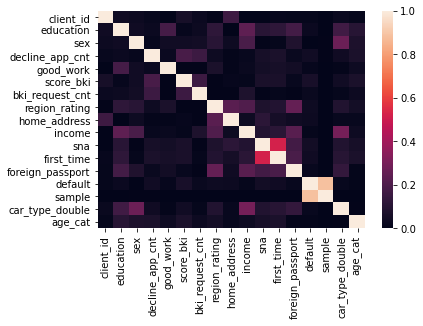

In [52]:
display(data.corr())
sns.heatmap(data.corr().abs(), vmin=0, vmax=1)

In [53]:
num_cols2 = ['score_bki','decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols2 = ['education', 'region_rating', 'home_address', 'sna', 'first_time', 'car_type_double']
bin_cols2 = ['age_cat', 'sex', 'good_work', 'foreign_passport']

<AxesSubplot:>

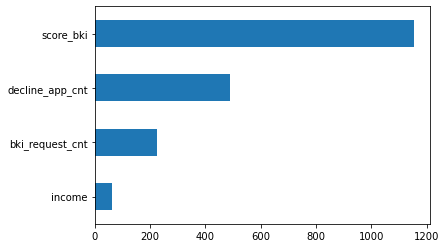

In [54]:
imp_num = pd.Series(f_classif(data[num_cols2], data['default'])[0], index = num_cols2)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [55]:
data.education.value_counts()

1    57998
3    34768
2    14748
4     1865
0      478
5      291
Name: education, dtype: int64

<AxesSubplot:>

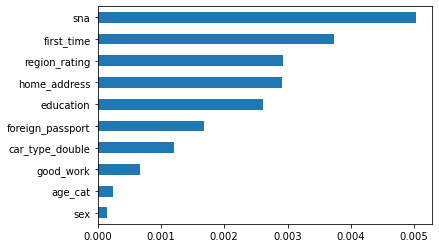

In [56]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols2 + cat_cols2], data['default'],
                                     discrete_features = True), index = bin_cols2 + cat_cols2)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [57]:
for col in num_cols2:
    data[col] = data[col].apply(lambda x: np.log(x**2+1))

In [58]:
#pf = PolynomialFeatures(degree = 2)
#data_pf = pf.fit_transform(data[num_cols2])[:, len(num_cols2) + 1:]
#cols_pf = pf.get_feature_names()[len(num_cols2) + 1 :]

# добавляем новые полиномиальные значения к датасету
#data = pd.concat([data, pd.DataFrame(data_pf, columns = cols_pf)], axis=1)

# добавляем новые полиномиальные признаки к датасету
#num_cols2.extend(pf_columns)


Можно попробовать использовать только категориальные признаки, т.к. бинарные заметно меньше влияют на целевую переменную

Прверим как теперь работает модель с новыми признаками

In [59]:
train_df = data.query('sample == 1').drop(['sample'], axis=1)
test_df = data.query('sample == 0').drop(['sample'], axis=1)

y = train_df['default'].values

X_num = StandardScaler().fit_transform(train_df[num_cols2].values)

X_cat = OneHotEncoder(sparse = False).fit_transform(train_df[cat_cols2].values)

X = np.hstack([X_num, train_df[bin_cols2].values, X_cat])

#X = np.hstack([X_num, X_cat])

X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
print_logisitc_metrics(y_train, y_pred)
display(confusion_matrix(y_train, y_pred))

accuracy_score: 0.872
precision_score: 0.491
recall_score: 0.03
f1_score: 0.057
MSE: 0.128


array([[51258,   236],
       [ 7317,   228]], dtype=int64)

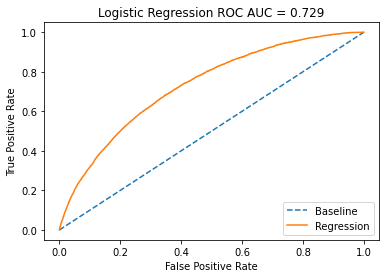

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_train)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_train, probs)
roc_auc = roc_auc_score(y_train, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [61]:
for models in model_list:
    model = models

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Информация по модели: ' + str(models))
    print_logisitc_metrics(y_test, y_pred)
    display(confusion_matrix(y_test, y_pred))

Информация по модели: LogisticRegression()
accuracy_score: 0.875
precision_score: 0.398
recall_score: 0.022
f1_score: 0.042
MSE: 0.125


array([[12871,    62],
       [ 1786,    41]], dtype=int64)

Информация по модели: DecisionTreeClassifier()
accuracy_score: 0.78
precision_score: 0.182
recall_score: 0.222
f1_score: 0.2
MSE: 0.22


array([[11110,  1823],
       [ 1422,   405]], dtype=int64)

Информация по модели: ExtraTreeClassifier()
accuracy_score: 0.795
precision_score: 0.188
recall_score: 0.198
f1_score: 0.192
MSE: 0.205


array([[11369,  1564],
       [ 1466,   361]], dtype=int64)

Информация по модели: AdaBoostClassifier()
accuracy_score: 0.875
precision_score: 0.402
recall_score: 0.025
f1_score: 0.046
MSE: 0.125


array([[12866,    67],
       [ 1782,    45]], dtype=int64)

Информация по модели: BaggingClassifier()
accuracy_score: 0.862
precision_score: 0.265
recall_score: 0.066
f1_score: 0.106
MSE: 0.138


array([[12597,   336],
       [ 1706,   121]], dtype=int64)

Информация по модели: GradientBoostingClassifier()
accuracy_score: 0.876
precision_score: 0.448
recall_score: 0.016
f1_score: 0.032
MSE: 0.124


array([[12896,    37],
       [ 1797,    30]], dtype=int64)

Информация по модели: RandomForestClassifier()
accuracy_score: 0.871
precision_score: 0.339
recall_score: 0.041
f1_score: 0.072
MSE: 0.129


array([[12789,   144],
       [ 1753,    74]], dtype=int64)

ROC AUC для модели: LogisticRegression()


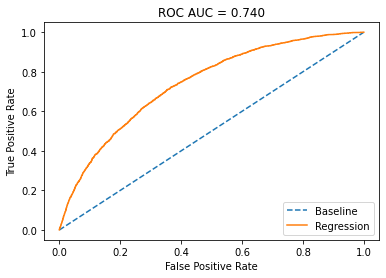

ROC AUC для модели: DecisionTreeClassifier()


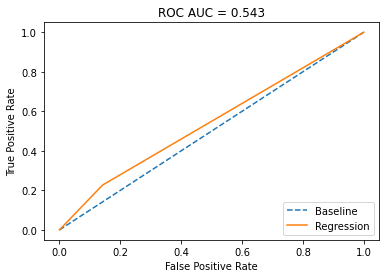

ROC AUC для модели: ExtraTreeClassifier()


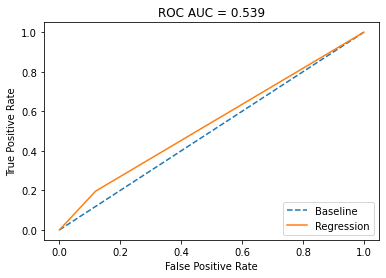

ROC AUC для модели: AdaBoostClassifier()


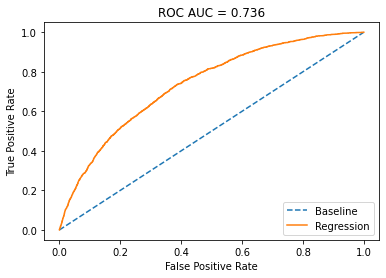

ROC AUC для модели: BaggingClassifier()


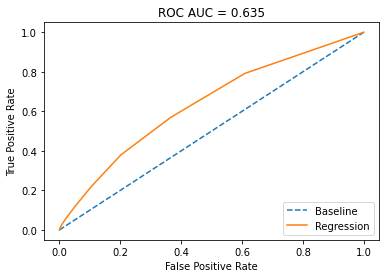

ROC AUC для модели: GradientBoostingClassifier()


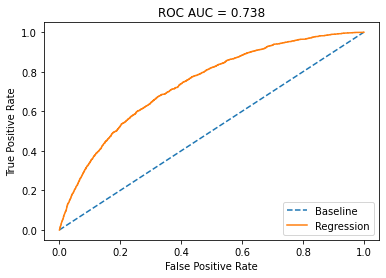

ROC AUC для модели: RandomForestClassifier()


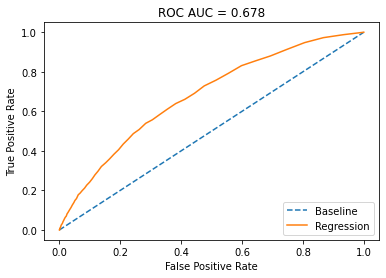

In [62]:
for models in model_list:
    model = models
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:,1]


    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    print('ROC AUC для модели: ' + str(models))
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

На данном этапе все добавления/изменения/удаления и так далее признаков, которые были испробованы не приводят к заметным улучшениям результата. f1-score увеличивается в некоторых сценариях, моделях и наборах данных, но ROC AUC систематически падает с момента первой модели.

Считаю, что на этом можно сейчас остановится, нужно больше данных, которые бы сбалансировали целевую переменную.

Создание полиномиальных признаков приводит к большому количеству новых признаков и к падению ROC AUC

Логарифмирование числовых признаков также не приводит к желаемому результату.

Гиперпараметр class_weight='balanced', который позволяет поднять f1-score, но в то же время снижается accuracy_score и немного ROC AUC.

# Ниже итоговый вариант набора признаков и модели

accuracy_score: 0.875
precision_score: 0.396
recall_score: 0.021
f1_score: 0.04
MSE: 0.125


array([[12875,    58],
       [ 1789,    38]], dtype=int64)

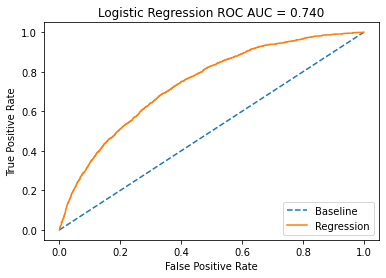

In [63]:
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(['sample'], axis=1)

X_cat = OneHotEncoder(sparse = False).fit_transform(train_df[cat_cols].values)

# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train_df[num_cols].values)

X = np.hstack([X_num, train_df[bin_cols].values, X_cat])
Y = train_df['default'].values

#Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print_logisitc_metrics(y_test, y_pred)
display(confusion_matrix(y_test, y_pred))

model = LogisticRegression()
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [64]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_df[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test_df[num_cols].values)
X_test = np.hstack([X_num_test, test_df[bin_cols].values, X_cat_test])
y_probs = model.predict_proba(X_test)[:,1]

In [65]:
test_df['default'] = y_probs

In [66]:
submission = test_df[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

client_id   default
107672      46449  0.024680
83473       94220  0.214854
97878      100766  0.032730
87920       14767  0.165176
84984       93351  0.239388
75725       34677  0.098436
91135       18343  0.278902
92381       55552  0.254840
81381       40120  0.089666
96755       90526  0.148485

(36349, 2)

In [67]:
submission.to_csv('submission.csv', index=False)